### Import libraries

In [1]:
from libs.Dataset import TripletTrashbinDataModule
from libs.Model import TripletNetworkTask,TripletNetworkTaskV2, evaluating_performance
from torch import nn
from torchvision.models import squeezenet1_1
import torch
import pytorch_lightning as pl
from torchvision.models import squeezenet1_1
from torch import nn
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import progress
from torchvision.models import squeezenet1_1
from torch import nn
import torch
# or to ignore all warnings that could be false positives
import warnings
warnings.filterwarnings("ignore")
from pytorch_lightning.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=PossibleUserWarning)
import dill

In [2]:
class_dict = {
    0: 'empty',
    1: 'half',
    2: 'full'
}

data_img_size = 224
data_batch_size = 256
# otherwise, return warning
n_workers = 0  # os.cpu_count()

Load del dataModule

In [3]:
dm = TripletTrashbinDataModule(img_size=data_img_size,num_workers=n_workers)
# dm.prepare_data()
dm.setup()

### Loading squeezeNet

In [4]:
squeezeNet = squeezenet1_1(pretrained=True)
squeezeNet.classifier = nn.Identity()

Dimensione delle feature richieste dal modello <b>TODO: scrivi meglio</b>

In [5]:
squeezeNet(torch.zeros(1,3,data_img_size,data_img_size)).shape

torch.Size([1, 86528])

### Triplet squeezeNet v1

In [5]:
triplet_squeezeNet = TripletNetworkTask(squeezeNet, lr=0.002, batch_size=data_batch_size) # parto dal LR trovato nel precedente studio

Utilizzando le funzioni di libreria di pytorch_lighting controllo la dimensione del batch <b>SCRIVI MEGLIO</b>

In [7]:
trainer = pl.Trainer(auto_scale_batch_size="power", max_epochs=-1)
trainer.tune(triplet_squeezeNet, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Batch size 2 succeeded, trying batch size 4
Batch size 4 succeeded, trying batch size 8
Batch size 8 succeeded, trying batch size 16
Batch size 16 succeeded, trying batch size 32
Batch size 32 succeeded, trying batch size 64
Batch size 64 succeeded, trying batch size 128
Batch size 128 succeeded, trying batch size 256
Batch size 256 succeeded, trying batch size 512
Batch size 512 succeeded, trying batch size 1024
Batch size 1024 succeeded, trying batch size 2048
Batch size 2048 succeeded, trying batch size 4096
Batch size 4096 succeeded, trying batch size 8192
Batch size 6600 succeeded, trying batch size 13200
Finished batch size finder, will continue with full run using batch size 6600
Restoring states from the checkpoint path at /Users/danilo/GitHub/deep-learning/.scale_batch_size_cd046314-3d33-42b7-8bb2-55d987f7354e.ckpt


{'scale_batch_size': 6600}

Utilizzando la funzione di libreria di pytorch lighting vedo qual è il migliore LR <b>SCRIVI MEGLIO</b>

In [8]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tune(triplet_squeezeNet, datamodule=dm)
# TODO: trova il modo di fare il grafico del LR trovato!
# triplet_mobileNet.hparams.lr = new_lr # TODO: da verificare se si deve fare così o col costruttore
# TODO: SOStituisci il LR
lr_finder


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 56 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/danilo/GitHub/deep-learning/.lr_find_fef24b37-73d2-41af-9971-1de88345f9fe.ckpt
Learning rate set to 7.585775750291837e-08


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x1078dc280>}

In [9]:
dill.dump_session('backup_session_1.pkl')

Valuto le performance prima del training

In [5]:
triplet_squeezeNet = TripletNetworkTask(squeezeNet, lr=7.585775750291837e-08, batch_size=data_batch_size)
# TODO: Instanzio nuovamente il TripletNetworkTask con batch_size e lr in base al risultato di sopra ^ 

100%|██████████| 124/124 [06:59<00:00,  3.38s/it]


Classification error before training 6.855654600401044


100%|██████████| 124/124 [07:01<00:00,  3.40s/it]


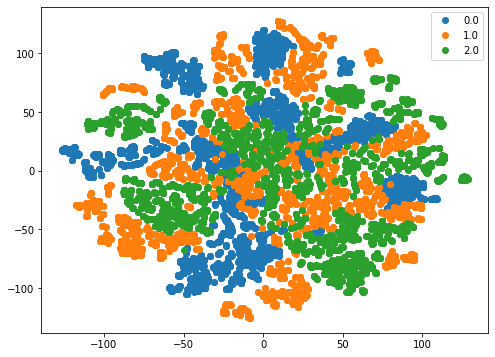

In [6]:
evaluating_performance(triplet_squeezeNet, dm, data_batch_size)

Alleno il modello per 10 epoche con loss A

In [7]:
logger = TensorBoardLogger("models/logs", name="triplet_squeezeNet_v1")

trainer = pl.Trainer(gpus=0,
                    max_epochs=11,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto",
                    )

trainer.fit(model=triplet_squeezeNet, datamodule=dm)
trainer.save_checkpoint('models/triplet_squeezeNet_v1_{}_batch.ckpt'.format(data_batch_size) )
torch.save(trainer.model.state_dict(), 'models/triplet_squeezeNet_v1_{}_batch.pth'.format(data_batch_size))


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: models/logs/triplet_squeezeNet_v1

  | Name          | Type              | Params
----------------------------------------------------
0 | embedding_net | SqueezeNet        | 722 K 
1 | criterion     | TripletMarginLoss | 0     
----------------------------------------------------
722 K     Trainable params
0         Non-trainable params
722 K     Total params
2.890     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Valuto le performance ottenute

100%|██████████| 124/124 [07:02<00:00,  3.40s/it]


Classification error before training 1.7320508075688772


100%|██████████| 124/124 [07:38<00:00,  3.70s/it]


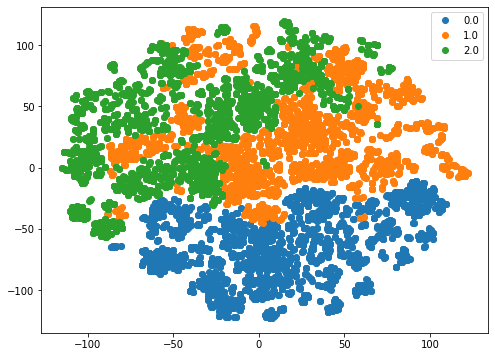

In [8]:
evaluating_performance(triplet_squeezeNet, dm, data_batch_size)

### Triplet squeezeNet v2

In [5]:
triplet_squeezeNet_v2 = TripletNetworkTaskV2(squeezeNet, lr=0.002, batch_size=data_batch_size) # parto dal LR trovato nel precedente studio

In [6]:
trainer = pl.Trainer(auto_lr_find=True)
lr_finder = trainer.tune(triplet_squeezeNet_v2, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 56 steps due to diverging loss.
Restoring states from the checkpoint path at /Users/danilo/GitHub/deep-learning/.lr_find_ddaddba9-e367-4607-a0c2-e1459fbc6b89.ckpt
Learning rate set to 7.585775750291837e-08


In [7]:
dill.dump_session('backup_session_2.pkl')

In [6]:
triplet_squeezeNet_v2 = TripletNetworkTaskV2(squeezeNet, lr=7.585775750291837e-08, batch_size=data_batch_size)

100%|██████████| 124/124 [07:08<00:00,  3.45s/it]


Classification error 6.855654600401044


100%|██████████| 124/124 [07:09<00:00,  3.46s/it]


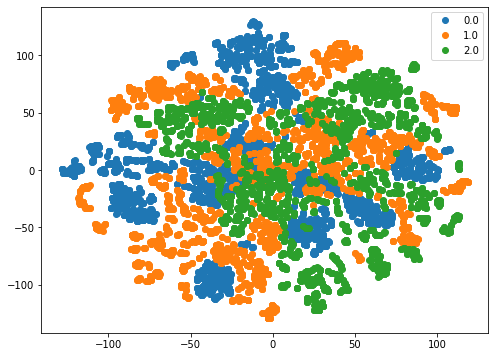

In [9]:
evaluating_performance(triplet_squeezeNet_v2, dm)

In [10]:
# TODO: fai load from ckpt e completa le ultime 30 epoche

logger = TensorBoardLogger("models/logs", name="triplet_squeezeNet_v2")

trainer = pl.Trainer(gpus=0,
                    max_epochs=31,
                    callbacks=[progress.TQDMProgressBar()],
                    logger=logger,
                    accelerator="auto",
                    )

trainer.fit(model=triplet_squeezeNet_v2, datamodule=dm)
trainer.save_checkpoint('models/triplet_squeezeNet_v2_{}_batch.ckpt'.format(data_batch_size) )
torch.save(trainer.model.state_dict(), 'models/triplet_squeezeNet_v2_{}_batch.pth'.format(data_batch_size))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: models/logs/triplet_squeezeNet_v2

  | Name          | Type                          | Params
----------------------------------------------------------------
0 | embedding_net | SqueezeNet                    | 722 K 
1 | criterion     | TripletMarginWithDistanceLoss | 0     
----------------------------------------------------------------
722 K     Trainable params
0         Non-trainable params
722 K     Total params
2.890     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
evaluating_performance(triplet_squeezeNet_v2, dm)